# I) Summary

**DISCLAIMER**: We will use a simplier version of the LeNet-5 than the one in the [paper](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf). (For example, computation on average pooling layers described in the paper are slightly more complex than usual).

LeNet-5 has:

- 2 Convolutional layers.
- 3 Fully connected layers.
- 2 Average pooling layers.
- Tanh as activation function for hidden layer.
- Softmax as activation function for output layer.
- 60000 trainable parameters.
- Cross-entropy as cost function
- Gradient descent as optimizer.

LeNet-5 is:

- trained on MNIST dataset (60000 training examples).
- trained over 20 epoch.

LeNet-5 is expected to:
- converge after 10-12 epoch.
- have an error rate of 0.95% on test set. (Using accuracy as mettric)

![legend](../../img/legend.png)

![LeNet-5 model](../../img/lenet5-model.png)

# II) Implementation

In [1]:
from IPython.display import clear_output
import shutil
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from torchvision import transforms, datasets
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## a) Loading dataset / Preprocessing

Notice:

- Pytorch let us preprocess our data (reshaping, normalizing) while loading our data.
- the format used for the image is the following: (n, C, H, W).

In [2]:
def load_mnist():
    transform = transforms.Compose([transforms.Resize((32,32)),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.5], std=[0.5])])
            
    train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST('./data', train=False, download=True, transform=transform)
    
    # Clear downloading message.
    clear_output()
    
    # Split dataset into training set and validation set.
    train_dataset, val_dataset = random_split(train_dataset, (55000, 5000))
    
    print("Image Shape: {}".format(train_dataset[0][0].numpy().shape), end = '\n\n')
    print("Training Set:   {} samples".format(len(train_dataset)))
    print("Validation Set:   {} samples".format(len(val_dataset)))
    print("Test Set:       {} samples".format(len(test_dataset)))
    
    # Create iterator.
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=True)
    
    # Delete the data/ folder.
    shutil.rmtree('./data')
    
    return (train_loader, val_loader, test_loader)

In [3]:
train_loader, val_loader, test_loader = load_mnist()

Image Shape: (1, 32, 32)

Training Set:   55000 samples
Validation Set:   5000 samples
Test Set:       10000 samples


---  
 <b>transforms.Normalize(mean=[0.5], std=[0.5])</b> ->  Normalize images over 1 channel in the range [-1,1].
 
 $$image[channel] = \frac{image[channel] - mean[channel]}{std[channel]}$$
 - <b>PROOF:</b> 
     - if $image[channel] = 0$ (minimum value) then $\frac{0 - 0.5}{0.5} = -1$.
     - if $image[channel] = 1$ (maximum value) then $\frac{1 - 0.5}{0.5} = 1$.
 

Thus it normalize images in the range of [-1,1].


## b) Visualization

In [4]:
def plot_example(X, y, y_pred=None):
    """
        Plots 9 examples and their associate labels.
        
        Parameters:
        -X: Training examples.
        -y: true labels.
        -y_pred: predicted labels.
    """
    # Create figure with 3 x 3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
     
    X, y = X[:9, 0, ...], y[:9] 
    
    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(X[i])

        # Show true and predicted classes.
        if y_pred is None:
            xlabel = "True: {0}".format(y[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(y[i], y_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots in a single Notebook cell.
    plt.show()

In [5]:
def plot_example_errors(X, y, y_pred):
    """
        Plots 9 example errors and their associate true/predicted labels.
        
        Parameters:
        -X: Training examples.
        -y: true labels.
        -y_pred: predicted labels.
    
    """
    incorrect = (y != y_pred)
 
    X = X[incorrect]
    y = y[incorrect]
    y_pred = y_pred[incorrect]

    # Plot the first 9 images.
    plot_example(X, y, y_pred)

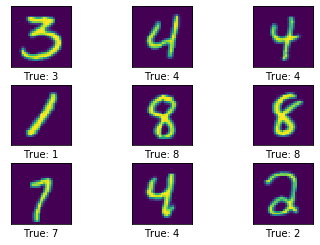

In [6]:
images, labels = iter(train_loader).next()
plot_example(images.numpy(), labels.numpy())

## c) Architecture build

In [7]:
class LeNet_5(nn.Module):
    
    def __init__(self):
        super(LeNet_5, self).__init__()
        
        self.C1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=(5,5))
        self.P1 = nn.AvgPool2d(kernel_size=(2,2), stride=2)
        self.C2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=(5,5))
        self.P2 = nn.AvgPool2d(kernel_size=(2,2), stride=2)

        self.FC1 = nn.Linear(in_features=16*5*5, out_features=120)
        self.FC2 = nn.Linear(in_features=120, out_features=84)
        self.FC3 = nn.Linear(in_features=84, out_features=10)  
        
        
    def forward(self, x):
        x = torch.tanh(self.C1(x))
        x = self.P1(x)
        x = torch.tanh(self.C2(x))
        x = self.P2(x)
        x = x.view(-1, 16*5*5)
        x = torch.tanh(self.FC1(x))
        x = torch.tanh(self.FC2(x))
        # No need to use softmax because it is already called in
        # nn.CrossEntropyLoss().
        x = self.FC3(x)
    
        return x

In [8]:
model = LeNet_5()
model

LeNet_5(
  (C1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (P1): AvgPool2d(kernel_size=(2, 2), stride=2, padding=0)
  (C2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (P2): AvgPool2d(kernel_size=(2, 2), stride=2, padding=0)
  (FC1): Linear(in_features=400, out_features=120, bias=True)
  (FC2): Linear(in_features=120, out_features=84, bias=True)
  (FC3): Linear(in_features=84, out_features=10, bias=True)
)

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

## d) Training the model

In [10]:
def train_model():
    EPOCHS = 20
    nb_examples = 55000
    nb_val_examples = 5000
    train_costs, val_costs = [], []
    
    #Training phase.
    
    for epoch in range(EPOCHS):
        
        train_loss = 0
        correct_train = 0
        
        for inputs, labels in train_loader:
            # Zero the parameter gradients.
            optimizer.zero_grad()
            
            # Forward pass.
            prediction = model(inputs)
            
            # Compute the loss.
            loss = criterion(prediction, labels)
            
            # Backward pass.
            loss.backward()
            
            # Optimize.
            optimizer.step()
            
            # Compute training accuracy.
            _, predicted = torch.max(prediction.data, 1)
            correct_train += (predicted == labels).sum().item()
            
            # Compute batch loss.
            train_loss += (loss.data.item() * inputs.shape[0])

        train_loss /= nb_examples
        train_costs.append(train_loss)
        train_acc =  correct_train / nb_examples
        
        val_loss = 0
        correct_val = 0

        for inputs, labels in val_loader:
            # Zero the parameter gradients.
            optimizer.zero_grad()
             
            # Forward pass.
            prediction = model(inputs)
            
            # Compute the loss.
            loss = criterion(prediction, labels)
            
            # Backward pass.
            loss.backward()
            
            # Optimize.
            optimizer.step()
            
            # Compute training accuracy.
            _, predicted = torch.max(prediction.data, 1)
            correct_val += (predicted == labels).sum().item()
            
            # Compute batch loss.
            val_loss += (loss.data.item() * inputs.shape[0])

        val_loss /= nb_val_examples
        val_costs.append(val_loss)
        val_acc =  correct_val / nb_val_examples
        
        info = "[Epoch {}/{}]: train-loss = {:0.6f} | train-acc = {:0.3f} | val-loss = {:0.6f} | val-acc = {:0.3f}"
        print(info.format(epoch+1, EPOCHS, train_loss, train_acc, val_loss, val_acc))
                                                                
    torch.save(model.state_dict(), 'lenet5_model')  
    return train_costs, val_costs

In [11]:
train_costs, val_costs = train_model()

[Epoch 1/20]: train-loss = 2.161053 | train-acc = 0.321 | val-loss = 1.745551 | val-acc = 0.603
[Epoch 2/20]: train-loss = 1.152115 | train-acc = 0.737 | val-loss = 0.776660 | val-acc = 0.825
[Epoch 3/20]: train-loss = 0.625051 | train-acc = 0.850 | val-loss = 0.521787 | val-acc = 0.872
[Epoch 4/20]: train-loss = 0.465169 | train-acc = 0.880 | val-loss = 0.422384 | val-acc = 0.889
[Epoch 5/20]: train-loss = 0.392928 | train-acc = 0.892 | val-loss = 0.369454 | val-acc = 0.900
[Epoch 6/20]: train-loss = 0.349584 | train-acc = 0.902 | val-loss = 0.334451 | val-acc = 0.909
[Epoch 7/20]: train-loss = 0.317997 | train-acc = 0.910 | val-loss = 0.307354 | val-acc = 0.916
[Epoch 8/20]: train-loss = 0.292301 | train-acc = 0.916 | val-loss = 0.284597 | val-acc = 0.922
[Epoch 9/20]: train-loss = 0.270288 | train-acc = 0.922 | val-loss = 0.263995 | val-acc = 0.927
[Epoch 10/20]: train-loss = 0.250795 | train-acc = 0.928 | val-loss = 0.245879 | val-acc = 0.931
[Epoch 11/20]: train-loss = 0.233262 | 

--- 
We know that:

\begin{align*} 
\text{# batches} &= \frac{\text{# examples}}{\text{Batch_Size}} \\\\
\frac{1}{\text{# batches}} &= \frac{\text{Batch_Size}}{\text{# examples}}
\end{align*}

We can directly divide <b>batch_cost</b> by <b># batches</b> only if every batch has the same size. If not multiply each <b>batch_cost</b> by its <b>batch_size</b> and then divide by <b># examples</b>. Same reasoning applied to validation accuracy computation.

## e) Evaluating the model

In [12]:
# Restore the model.
model = LeNet_5()
model.load_state_dict(torch.load('lenet5_model'))

<All keys matched successfully>

Test set error rate: 0.9655

Some correct classification:


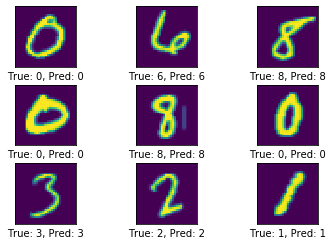


Some incorrect classification:


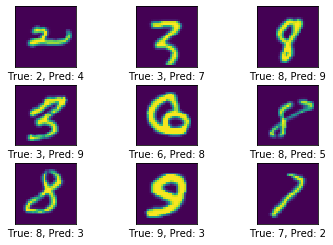


Plot of training/validation error over 20 epochs:


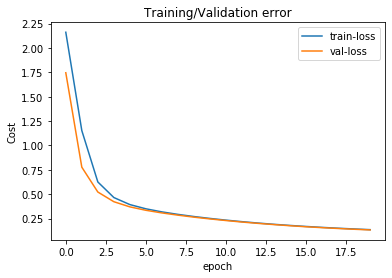

In [17]:
# Create iterator.
dataiter = iter(test_loader)
images, labels = dataiter.next()

# Make predictions.
predictions = model(images)

# Retrieve predictions indexes.
_, predicted = torch.max(predictions, 1)

# Compute number of correct predictions.
correct = (predicted == labels).sum().item()

# Compute accuracy on test set.
test_accuracy = correct / images.shape[0]
print('Test set error rate: {}'.format(test_accuracy))

# Plot some examples with model predictions.
print('\nSome correct classification:')
plot_example(images.numpy(), labels.numpy(), predicted.numpy())

print('\nSome incorrect classification:')
plot_example_errors(images.numpy(), labels.numpy(), predicted.numpy())

# Plot training error.
print('\nPlot of training/validation error over 20 epochs:')
plt.title('Training/Validation error')
plt.ylabel('Cost')
plt.xlabel('epoch')

plt.plot(train_costs)
plt.plot(val_costs)
plt.legend(['train-loss', 'val-loss'], loc='upper right')
plt.show()

# III) Conclusion

We can conclude that:

- The test set error (accuracy) is greater than 0.95 % (0.0.9655 %).
- It seems to start converging after 10-12 epochs.